## Outliers

An outlier is a data point which is significantly different from the remaining data. "An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism." [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980.]


### Should outliers be removed?

Depending on the context, outliers either deserve special attention or should be completely ignored. Take the example of revenue forecasting: if unusual spikes of revenue are observed, it's probably a good idea to pay extra attention to them and figure out what caused the spike. In the same way, an unusual transaction on a credit card is usually a sign of fraudulent activity, which is what the credit card issuer wants to prevent. So in instances like these, it is useful to look for and investigate further outlier values.

If outliers are however, introduced due to mechanical error, measurement error or anything else that can't be generalised, it is a good idea to remove these outliers before feeding the data to the modeling algorithm. Why? Because some algorithms are sensitive to outliers. 


### Which machine learning models are sensitive to outliers?

Some machine learning models are more sensitive to outliers than others. For instance, AdaBoost may treat outliers as "hard" cases and put tremendous weights on outliers, therefore producing a model with bad generalisation.

Linear models, in particular Linear Regression, can be also sensitive to outliers.

Decision trees tend to ignore the presence of outliers when creating the branches of their trees. Typically, trees make decisions by asking if variable x >= a certain value, and therefore the outlier will fall on each side of the branch, but it will be treated equally than the remaining values, regardless of its magnitude.

A recent research article suggests that Neural Networks could also be sensitive to outliers, provided the number of outliers is high and the deviation is also high. I would argue that if the number of outliers is high (>15% as suggested in the article), then they are no longer outliers, and rather a fair representation of that variable. A link to this article can be found in the "Additional reading resources" lecture within this section of the course.


### How can outliers be identified?

Outlier analysis and anomaly detection are a huge field of research devoted to optimise methods and create new algorithms to reliably identify outliers. There are a huge number of ways optimised to detect outliers in different situations. These are mostly targeted to identify outliers when those are the observations that we indeed want to focus on, for example for fraudulent credit card activity.

In this course, however, I will focus on identifying those outliers introduced by mechanical or measurement error. Those outliers that are indeed a rare case in the population, and that could be ignored. I will show how to identify those outliers, so that in later sections of the course, we can learn how to pre-process them before using the variable to train machine learning algorithms.


### Extreme Value Analysis

The most basic form of outlier detection is **Extreme Value Analysis** of 1-dimensional data. The key for this method is to determine the statistical tails of the underlying distribution of the variable, and then find the values that sit at the very end of the tails.

If the the variable is Normally distributed (Gaussian), then the values that lie outside the mean plus or minus 3 times the standard deviation of the variable are considered outliers.

- outliers = mean +/- 3* std


If the variable is skewed distributed, a general approach is to calculate the quantiles, and then the inter-quantile range (IQR), as follows:

- IQR = 75th quantile - 25th quantile

An outlier will sit outside the following upper and lower boundaries:

- Upper boundary = 75th quantile + (IQR * 1.5)

- Lower boundary = 25th quantile - (IQR * 1.5)

or for extreme cases:

- Upper boundary = 75th quantile + (IQR * 3)

- Lower boundary = 25th quantile - (IQR * 3)



## Datasets for this notebook: 

### Predicting Survival on the Titanic: understanding society behaviour and beliefs

Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.


### Boston house prices dataset

In [1]:
# print information for boston dataset
from sklearn.datasets import load_boston
print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## In this demo

- Identify outliers using complete case analysis in Normally distributed variables.
- Identify outliers using complete case analysis in skewed variables.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import pylab
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

In [3]:
# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()

# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]


boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [4]:
# load the titanic dataset

titanic = pd.read_csv('titanic.csv', usecols=['Age','Fare'])


In [5]:
# The variable age has missing values, I will remove them for this demo
titanic.dropna(subset=['Age'], inplace=True)
titanic.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


## Identify variable distribution

In Normally distributed variables, outliers are those values that lie beyond the mean plus or minus 3 times the standard deviation. If the variables are skewed however, we find outliers using the inter-quantile range. In order to decide which method to utilise to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable utilising the first quartile, the median, the third quartile and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.
- The inter-quantile range (IQR), the box itself.
- The quantiles, 25th (Q1) is the lower and 75th (Q3) the upper end of the box.
- The wiskers, which extend to: 
  -- top whisker: Q3 + 1.5 x IQR
  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. Let's look at the examples below.

In [6]:
# function to create histogram, Q-Q plot and
# boxplot

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
    
    # define figure size
    plt.figure(figsize=(16,4))
    
    # Histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
    
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.ylabel('RM Quntiles')
    
    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

C:\Users\shanusingh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


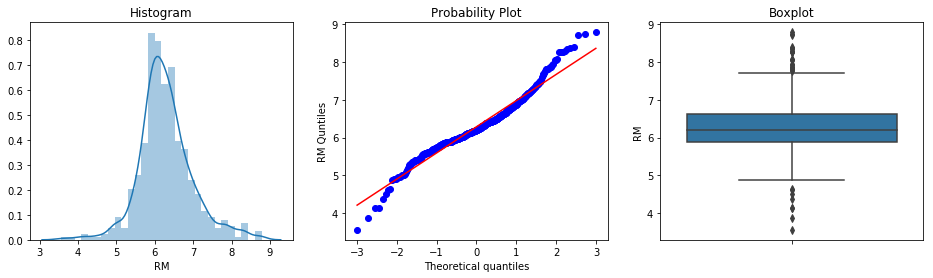

In [7]:
### Normally distributed variables
# let's start with the variable RM from the boston house dataset.
# RM is the average number of rooms per dwelling
diagnostic_plots(boston,'RM')


From the histogram and the Q-Q plot, we see that the variable RM approximates a Gaussian distribution quite well. In the boxplot, we see that the variable could have outliers, as there are many dots sitting outside the whiskers, at both tails of the distribution.

C:\Users\shanusingh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


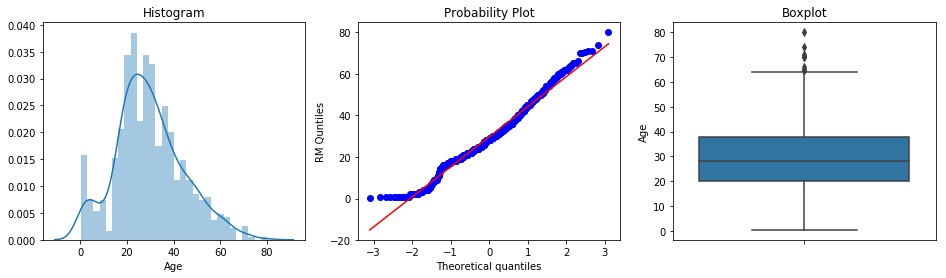

In [8]:
# let's inspect now the variable Age from the titanic refers to the age of the passengers on board
diagnostic_plots(titanic,'Age')

From the histogram and the Q-Q plot, we see that the variable approximates fairly well a Gaussian distribution. There is a deviation from the distribution towards the smaller values of age. In the boxplot, we can see that the variable could have outliers, as there are many dots sitting outside the whiskers, at the right end of the distribution (top whisker in the boxplot).

### Skewed variables

C:\Users\shanusingh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


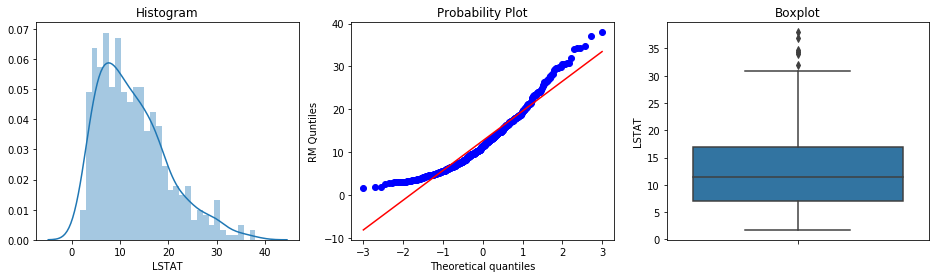

In [9]:
# variable LSTAT from the boston house dataset
# LSTAT is the % lower status of the population
diagnostic_plots(boston,'LSTAT')

LSTAT is not normally distributed, it is skewed with a tail to the right. According to the boxplot, there are some outliers at the right end of the distribution of the variable.

C:\Users\shanusingh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


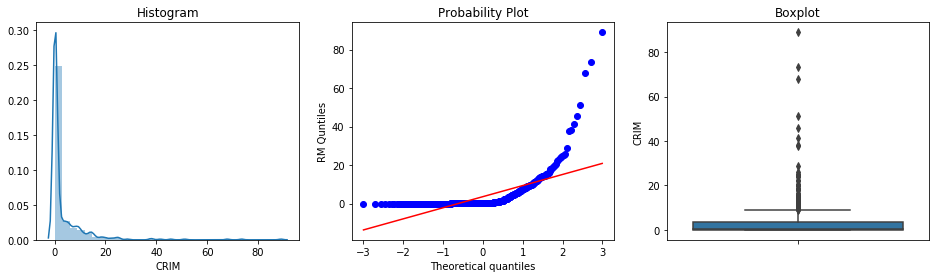

In [10]:
# variable CRIM from the boston house dataset
# CRIM is the per capita crime rate by town
diagnostic_plots(boston, 'CRIM')

CRIM is heavily skewed, with a tail to the right. There seems to be quite a few outliers as well at the right end of the distribution, according to the boxplot.

C:\Users\shanusingh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


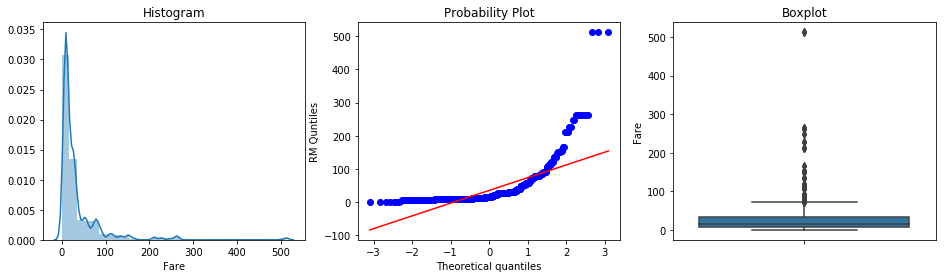

In [11]:
# variable Fare from the titanic dataset
#Fare is the price paid for the ticket by
# the passengers
diagnostic_plots(titanic, 'Fare')

Fare is also very skewed, and shows some unusual values at the right end of its distribution.

In the next cells We will identify outliers using the mean and the standard deviation for the variables RM and Age from the boston and titanic datasets, respectively. Then we will use the inter-quantile range to identify outliers for the variables LSTAT, CRIM and Fare from the boston and titanic datasets.

### Complete case analysis for Normally distributed variables

In [12]:
# function to find upper and lower boundaries for normally distributed variables

def find_normal_boundaries(df, variable):
    
    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution
    
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()
    
    return upper_boundary, lower_boundary
    

In [14]:
# calculate boundaries for RM
upper_boundary, lower_boundary = find_normal_boundaries(boston,'RM')
upper_boundary, lower_boundary

(8.392485817597757, 4.176782957105816)

From the above we conclude that values bigger than 8.4 or smaller than 4.2 occur very rarely for the variable RM. Therefore, we can consider them outliers.

In [51]:
# Inspect the number and percentage of outliers for RM

print('Total number of houses: {}'.format(len(boston)))
print('=======================================================')
print('House with more than 8.4 rooms (Right end outliers): {}'.format(len(boston[boston['RM'] > upper_boundary])))
print('House with less than 4.2 rooms(left end outliers): {}'.format(len(boston[boston['RM'] < lower_boundary])))
print('=======================================================')
print("% right end outliers: {}".format(len(boston[boston['RM'] > upper_boundary]) / len(boston)))
print('% left end outliers: {}'.format(len(boston[boston['RM'] < lower_boundary]) / len(boston)))

Total number of houses: 506
House with more than 8.4 rooms (Right end outliers): 0
House with less than 4.2 rooms(left end outliers): 0
% right end outliers: 0.0
% left end outliers: 0.0


Using Extreme Value Analysis we identified outliers at both ends of the distribution of RM. The percentage of outliers is small (1.4% considering the 2 tails together), which makes sense, because we are finding precisely outliers. That is, rare values, rare occurrences.

Let's move on to Age in the titanic dataset.

In [28]:
# Calculate boundaries for Age in the titanic
upper_boundary, lower_boundary = find_normal_boundaries(titanic,'Age')
upper_boundary, lower_boundary

(73.27860964406095, -13.88037434994331)

The upper boundary is 73 years, which means that passengers older than 73 were very few, if any, in the titanic. The lower boundary is negative. Because negative age does not exist, it only makes sense to look for outliers utilising the upper boundary.

In [48]:
# lets look at the number and percentage of outliers
print('Total passengers: {}'.format(len(titanic)))
print('----------------------------------------------------------------')
print('Passengers older than 73 Age: {}'.format(len(titanic[titanic['Age'] > upper_boundary])))
print('-------------------------------------------------------------')
print('% of passengers older than 73 Age {}'.format(len(titanic[titanic['Age'] > upper_boundary]) / len(titanic)))

Total passengers: 714
----------------------------------------------------------------
Passengers older than 73 Age: 286
-------------------------------------------------------------
% of passengers older than 73 Age 0.4005602240896359


There were 2 passengers older than 73 on board of the titanic, which could be considered outliers, as the majority of the population where much younger.

### Complete case analysis for skewed variables



In [39]:
# function to find upper and lower boundaries for skewed distributed variables
def find_skewed_boundaries(df, variable, distance):
    
    # Let's calculate the boundaries outside which sit the outliers for skewed distributions

    # distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    
    return upper_boundary, lower_boundary

In [40]:
# looking for outliers, using the interquantile proximity rule IQR * 1.5, the standard metric
# For LSTAT in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'LSTAT', 1.5)
upper_boundary, lower_boundary

(31.962500000000006, -8.057500000000005)

In [52]:
# lets look at the number and percentage of outliers
# for LSTAT

print('Total houses: {}'.format(len(boston)))
print('-----------------------------------------------')
print('Houses with LSTAT bigger than 32: {}'.format(len(boston[boston['LSTAT'] > upper_boundary])))
print('------------------------------------------------')

print('% houses with LSTAT bigger than 32: {}'.format(len(boston[boston['LSTAT'] > upper_boundary])/len(boston)))
print('========================================================================================================')

Total houses: 506
-----------------------------------------------
Houses with LSTAT bigger than 32: 7
------------------------------------------------
% houses with LSTAT bigger than 32: 0.01383399209486166


The upper boundary shows a value of ~32. The lower boundary is negative, however the variable LSTAT does not take negative values. So to calculate the outliers for LSTAT we only use the upper boundary. This coincides with what we observed in the boxplot earlier in the notebook. Outliers sit only at the right tail of LSTAT's distribution.

We observe 7 houses, 1.3 % of the dataset, with extremely high values for LSTAT.

In [55]:
# looking for outliers, using the interquantile proximity rule
# IQR * 3, now I am looking for extremely high values

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'CRIM', 3)
upper_boundary, lower_boundary


(14.462195000000001, -10.7030675)

In [56]:
# lets look at the number and percentage of outliers for CRIM

print('total houses: {}'.format(len(boston)))

print('houses with CRIM bigger than 14: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary])))
print('================================================')
print('% houses with CRIM bigger than 14s: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary]) / len(boston)))

total houses: 506
houses with CRIM bigger than 14: 30
% houses with CRIM bigger than 14s: 0.05928853754940711


When using the 3  times inter-quantile range to find outliers, we find that ~6% of the houses show unusually high crime rate areas. For CRIM as well, the lower boundary is negative, so it only makes sense to use the upper boundary to calculate outliers, as the variable takes only positive values. This coincides with what we observed in CRIM's boxplot earlier in this notebook.

In [57]:
# finally, identify outliers in Fare in the titanic dataset. I will look again for extreme values
# using IQR * 3
upper_boundary, lower_boundary = find_skewed_boundaries(titanic, 'Fare', 3)
upper_boundary, lower_boundary


(109.35, -67.925)

In [58]:
# lets look at the number and percentage of passengers who paid extremely high Fares
print('total passengers: {}'.format(len(titanic)))

print('passengers older than 73 rooms: {}'.format(
    len(titanic[titanic['Fare'] > upper_boundary])))
print('-----------------------------------------------')
print('passengers older than 73 rooms: {}'.format(
    len(titanic[titanic['Fare'] > upper_boundary])/len(titanic)))


total passengers: 714
passengers older than 73 rooms: 44
-----------------------------------------------
passengers older than 73 rooms: 0.06162464985994398


For Fare, as well as for all the other variables in this notebook which show a tail to the right, the lower boundary is negative. So we will use the upper boundary to determine the outliers. We observe that 6% of the values of the dataset fall above the boundary. 